In [1]:
pip install pygmo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 58.3 MB/s eta 0:00:0000:0100:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pygmo import hypervolume
import warnings

warnings.filterwarnings("ignore")

In [3]:
class MOBGA_AOS:
    def __init__(
        self, maxFEs, N, D, M, Q, LP, Pc, Pm, dataset, test_set=False, cv=3, k=3
    ):
        self.maxFEs = maxFEs  # Maximum number of fitness evaluations
        self.N = N  # Population size
        self.D = D  # Number of dimensionality (original features)
        self.M = M  # Number of objectives
        self.Q = Q  # Number of crossover operators
        self.LP = LP  # Number of repeated generations for OSP
        self.Pc = Pc  # The crossover Probability
        self.Pm = Pm  # The mutation probability
        self.hv = []
        self.operators = [
            self.one_point_crossover,
            self.two_point_crossover,
            self.uniform_crossover,
            self.shuffle_crossover,
            self.reduced_surrogate_crossover,
        ]  # Initial crossover operators

        self.df = dataset
        X = self.df.iloc[:, : self.D].values
        y = self.df.iloc[:, -1:].values
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.3, random_state=30
        )
        self.test_set = test_set
        self.k = k
        self.cv = cv
        self.PF_generations_fitness = []
        self.PF_generations_indices = []
        self.fitness_cache = {}

    def initPop(self, N):
        return np.array([np.random.choice([0, 1], size=self.D) for _ in range(N)])

    def initOSP(self, Q):
        return np.full(Q, 1 / Q)

    def is_dominated(self, point, other_points):
        return np.any(
            np.all(other_points <= point, axis=1) & np.any(other_points < point, axis=1)
        )

    def dominate(self, pointA, pointB):
        return np.all(pointA <= pointB) & np.any(pointA < pointB)

    def identify_pareto_set(self, points):
        pareto_set = []
        indices = []
        for i, point in enumerate(points):
            if not self.is_dominated(point, points):
                pareto_set.append(point)
                indices.append(i)
        return np.array(pareto_set), np.array(indices)

    def dominanceComparison(self, P):
        Pd, Pnd = [], []
        if self.dominate(P[0], P[1]):
            Pnd.append(P[0])
            Pd.append(P[1])
        elif self.dominate(P[1], P[0]):
            Pnd.append(P[1])
            Pd.append(P[0])
        else:
            Pnd.append(P[0])
            Pnd.append(P[1])

        return Pnd, Pd

    def creditAssignment(self, P, R, q):
        Pnd, Pd = self.dominanceComparison(P)
        if len(Pd) != 0:
            for j in range(len(R)):
                if self.dominate(Pnd[0], R[j]):
                    self.nPenalty[q] += 1
                else:
                    self.nReward[q] += 1
        else:
            for i in range(len(R)):
                if not self.dominate(P[0], R[i]) and not self.dominate(P[1], R[i]):
                    self.nReward[q] += 1
                else:
                    self.nPenalty[q] += 1

    def is_valid_individual(self, individual):
        if np.all(individual == 0):
            return False
        return True

    def rouletteWheelSelection(self, P):
        return np.random.choice(len(P), p=list(P))

    def main(self):

        print("Start!")

        self.P = self.initPop(self.N)  # Initial population
        self.PQ = self.initOSP(self.Q)  # Initial probability of crossover operators
        self.nReward = np.zeros(self.Q)  # Initial nReward
        self.nPenalty = np.zeros(self.Q)  # Initial nPenality
        self.RD = np.zeros((self.LP, self.Q))  # Initial RD
        self.PN = np.zeros((self.LP, self.Q))  # Initial PN
        self.PF = None  # Initial Parreto-front
        k = 0 # Initial k
        nFe = 0 # Initial number of fitness calculations

        # calculating whole population fitness
        self.Pfitness = np.array(
            [self.calculate_fitness(individual) for individual in self.P]
        )

        # first generation parreto
        Pnd,Pnd_indices = self.identify_pareto_set(self.Pfitness)
        # saving generations data
        self.PF_generations_fitness.append(Pnd)
        self.PF_generations_indices.append(Pnd_indices)

        while nFe < self.maxFEs:
            Qfitness = []
            print(f"{int((nFe / self.maxFEs) * 100)}%")
            P_new = []
            for i in range(self.N // 2):
                operator_idx = self.rouletteWheelSelection(self.PQ)
                operator = self.operators[operator_idx]

                # Random parrent selection
                Pp_idx = np.random.choice(len(self.P), size=2, replace=False)
                Pp = self.P[Pp_idx]
                offsprings = np.array(operator(Pp[0], Pp[1], self.Pc))
                for j in range(len(offsprings)):
                    offsprings[j] = np.array(
                        self.uniform_mutation(offsprings[j], self.Pm)
                    )
                    if not self.is_valid_individual(offsprings[j]):
                        print("invalid")
                        rnd = np.random.randint(self.D)
                        offsprings[j][rnd] = 1
                P_new.extend(offsprings)
                nFe += 2
                offFitness = np.array(
                    [self.calculate_fitness(individual) for individual in offsprings]
                )
                self.creditAssignment(self.Pfitness[Pp_idx], offFitness, operator_idx)

                Qfitness.extend(offFitness)
            Qfitness = np.array(Qfitness)
            self.RD[k] = self.nReward
            self.PN[k] = self.nPenalty
            k += 1
            if k == self.LP:
                new_probs = self.updateOSP()
                self.PQ = np.array(new_probs)
                k = 0

            self.R = np.concatenate((self.P, P_new))
            self.Rfitness = np.concatenate((self.Pfitness, Qfitness), axis=0)
            selected_pop = self.environmentalSelection()
            self.P = self.R[selected_pop]
            self.Pfitness = self.Rfitness[selected_pop]

            # Soulution for faster convergence(remove duplicates so diversity is going up!)
            _, unique_indices = np.unique(self.P, axis=0, return_index=True)
            self.P = self.P[unique_indices]
            self.Pfitness = self.Pfitness[unique_indices]

            Pnd,Pnd_indices = self.identify_pareto_set(self.Pfitness)

            # saving generations data
            self.PF_generations_fitness.append(Pnd)
            self.PF_generations_indices.append(Pnd_indices)

        self.PF = np.array(Pnd)

        print("Done!")

        return self.P[Pnd_indices]

    def updateOSP(self):
        s1 = np.sum(self.RD, axis=0)
        s2 = np.sum(self.PN, axis=0)
        s3 = np.where(s1 == 0, 0.0001, s1)
        s4 = s1 / (s3 + s2)

        p = s4 / np.sum(s4)
        return p

    def calculate_fitness(self, individual):
        # caching fitness so code would be more efficient
        individual_key = tuple(individual.tolist())
        if individual_key in self.fitness_cache:
            return self.fitness_cache[individual_key]

        X_train = self.X_train[:, individual == 1]
        X_test = self.X_test[:, individual == 1]
        neigh = KNeighborsClassifier(n_neighbors=self.k)
        neigh.fit(X_train, self.y_train.ravel())
        if self.test_set:
            X = X_test
            y = self.y_test
        else:
            X = X_train
            y = self.y_train

        cv_scores = cross_val_score(neigh, X, y.ravel(), cv=self.cv)
        mean_accuracy = np.mean(cv_scores)
        fitness_value = (1 - mean_accuracy, np.sum(individual))
        self.fitness_cache[individual_key] = fitness_value
        return fitness_value

    def environmentalSelection(self):
        while True:
            pareto_fronts = self.nonDominatedSort(self.R, self.Rfitness)
            selected_pop = []
            for front in pareto_fronts:
                if len(selected_pop) + len(front) <= self.N:
                    selected_pop.extend(front)
                else:
                    crowding_distances = self.crowdingDistance(
                        self.Rfitness[front], len(front)
                    )
                    sorted_indices = np.argsort(crowding_distances)[::-1]
                    selected_pop.extend(
                        np.array(front)[sorted_indices][
                            : self.N - len(selected_pop)
                        ].tolist()
                    )
                    break

            return selected_pop

    def nonDominatedSort(self, population, fitness):
        pareto_fronts = []
        domination_count = {i: 0 for i in range(len(population))}
        dominated_solutions = {i: [] for i in range(len(population))}

        for i in range(len(population)):
            for j in range(i + 1, len(population)):
                if self.dominate(fitness[i], fitness[j]):
                    domination_count[j] += 1
                    dominated_solutions[i].append(j)
                elif self.dominate(fitness[j], fitness[i]):
                    domination_count[i] += 1
                    dominated_solutions[j].append(i)

        pareto_front = [i for i in range(len(population)) if domination_count[i] == 0]
        pareto_fronts.append(pareto_front)

        current_front = 0

        while len(pareto_fronts[current_front]) > 0:
            next_front = []

            for i in pareto_fronts[current_front]:
                for j in dominated_solutions[i]:
                    domination_count[j] -= 1
                    if domination_count[j] == 0:
                        next_front.append(j)

            current_front += 1
            pareto_fronts.append(next_front)

        return pareto_fronts[:-1]

    def crowdingDistance(self, front_fitness, num_individuals):
        distances = np.zeros(len(front_fitness))

        for obj_index in range(front_fitness.shape[1]):
            sorted_indices = np.argsort(front_fitness[:, obj_index])
            distances[sorted_indices[0]] = float("inf")
            distances[sorted_indices[-1]] = float("inf")

            for i in range(1, num_individuals - 1):
                distances[sorted_indices[i]] += (
                    front_fitness[sorted_indices[i + 1], obj_index]
                    - front_fitness[sorted_indices[i - 1], obj_index]
                )

        return distances

    def one_point_crossover(self, parent1, parent2, crossover_probability):
        if np.random.uniform() >= crossover_probability:
            return parent1, parent2
        chromosome_length = len(parent1)
        crossover_point = np.random.randint(1, chromosome_length)

        offspring1 = np.concatenate(
            (parent1[:crossover_point], parent2[crossover_point:])
        )
        offspring2 = np.concatenate(
            (parent2[:crossover_point], parent1[crossover_point:])
        )

        return offspring1, offspring2

    def two_point_crossover(self, parent1, parent2, crossover_probability):
        if np.random.uniform() >= crossover_probability:
            return parent1, parent2

        chromosome_length = range(1, len(parent1))
        crossover_points = np.sort(
            np.random.choice(chromosome_length, 2, replace=False)
        )

        start_point, end_point = crossover_points

        offspring1 = np.concatenate(
            (parent1[:start_point], parent2[start_point:end_point], parent1[end_point:])
        )
        offspring2 = np.concatenate(
            (parent2[:start_point], parent1[start_point:end_point], parent2[end_point:])
        )

        return offspring1, offspring2

    def uniform_crossover(self, parent1, parent2, crossover_probability):
        if np.random.uniform() >= crossover_probability:
            return parent1, parent2

        mask = np.random.choice([True, False], size=len(parent1))

        child1 = np.where(mask, parent1, parent2)

        child2 = np.where(mask, parent2, parent1)

        return child1, child2

    def shuffle_crossover(self, parent1, parent2, crossover_probability):
        if np.random.uniform() >= crossover_probability:
            return parent1, parent2

        chromosome_length = len(parent1)

        crossover_point = np.random.randint(1, chromosome_length)

        np.random.shuffle(parent1)
        np.random.shuffle(parent2)

        offspring1 = np.concatenate(
            (parent1[:crossover_point], parent2[crossover_point:])
        )
        offspring2 = np.concatenate(
            (parent2[:crossover_point], parent1[crossover_point:])
        )

        return offspring1, offspring2

    def reduced_surrogate_crossover(self, parent1, parent2, crossover_probability):
        if np.random.uniform() >= crossover_probability:
            return parent1, parent2
        chromosome_length = len(parent1)

        different_gene_indices = np.where(parent1 != parent2)[0]

        if len(different_gene_indices) == 0:
            crossover_point = np.random.randint(1, chromosome_length)
        else:
            crossover_point = np.random.choice(different_gene_indices)

        offspring1 = np.concatenate(
            (parent1[:crossover_point], parent2[crossover_point:])
        )
        offspring2 = np.concatenate(
            (parent2[:crossover_point], parent1[crossover_point:])
        )

        return offspring1, offspring2

    def uniform_mutation(self, individual, mutation_probability):
        mutated_individual = individual.copy()

        for i in range(len(mutated_individual)):
            if np.random.uniform() < mutation_probability:
                mutated_individual[i] = np.random.choice([0, 1])
        return mutated_individual

In [38]:
path = "/kaggle/input/ec-mobga-aos-hw/DS04.csv"
df = pd.read_csv(path)
maxFes = 2000
N = 100
D = df.shape[1] - 1
M = 2
Q = 5
LP = 5
Pc = 0.9
Pm = 1 / D
test_set = False

In [39]:
ma = MOBGA_AOS(maxFes, N, D, M, Q, LP, Pc, Pm, df,test_set)

In [40]:
OFS = ma.main()

Start!
0%
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
Done!


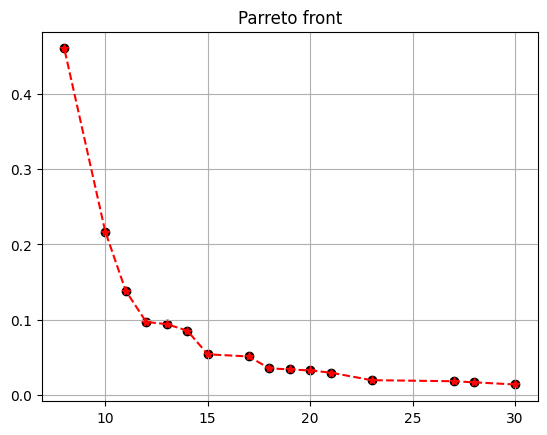

In [41]:
srt_part = np.array(sorted(ma.PF,key = lambda x:(-x[1],-x[0])))
plt.scatter(ma.PF[:,1], ma.PF[:,0],color="black")
plt.plot(srt_part[:, 1], srt_part[:, 0], "r*--")
plt.title("Parreto front")
plt.grid()
plt.show()

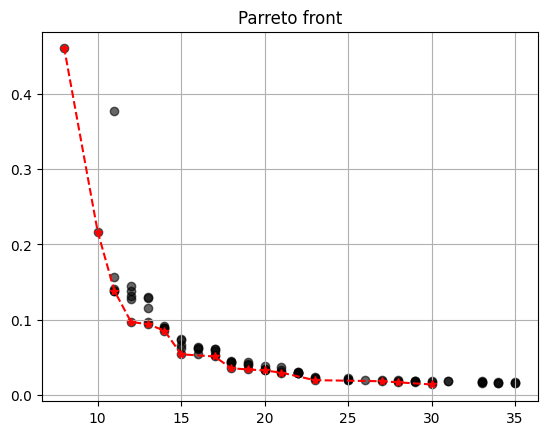

In [42]:
srt_part = np.array(sorted(ma.PF,key = lambda x:(-x[1],-x[0])))
plt.scatter(ma.Pfitness[:, 1], ma.Pfitness[:, 0], color="black", alpha=0.6)
plt.plot(srt_part[:, 1], srt_part[:, 0], "r*--")
plt.title("Parreto front")
plt.grid()
plt.show()

In [43]:
hv = []
for generation in ma.PF_generations_fitness:
    h = hypervolume(generation)
    hv.append(h.compute([1, D]))
hv_mean = np.mean(hv)
hv_std = np.std(hv)

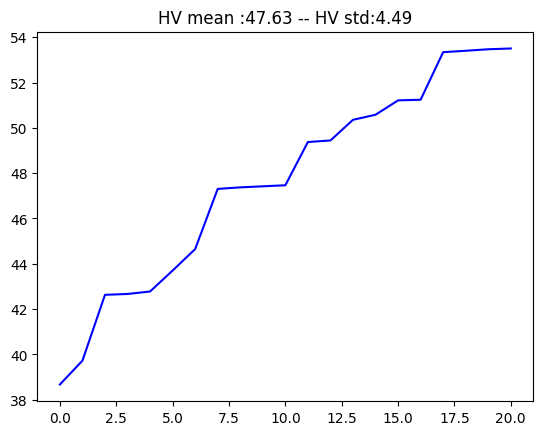

In [44]:
plt.plot(hv,"b-")
plt.title("HV mean :%1.2f -- HV std:%1.2f" %(hv_mean,hv_std))
plt.show()

In [45]:
def euclidean_distance(solution1, solution2):
    return np.linalg.norm(solution1 - solution2)

def calculate_igd(Z, A):
    total_distance = 0.0

    for a_solution in A:
        min_distance = float('inf')

        for z_solution in Z:
            distance = euclidean_distance(a_solution, z_solution)
            min_distance = min(min_distance, distance)

        total_distance += min_distance

    igd_value = total_distance / len(A)
    return igd_value

In [46]:
igd = []
for generation in ma.PF_generations_fitness:
    igd.append(calculate_igd(generation,ma.PF_generations_fitness[-1]))
igd_mean = np.mean(igd)
igd_std = np.std(igd)

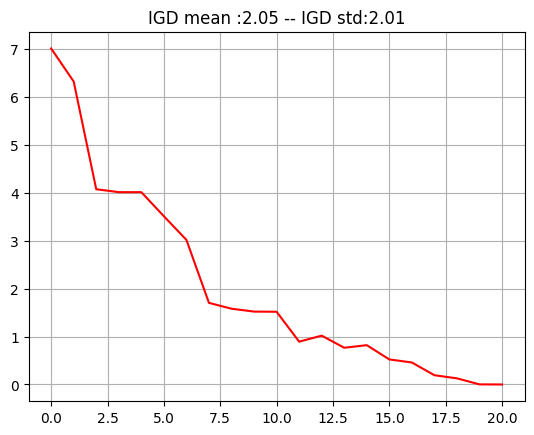

In [47]:
plt.plot(igd,"r-")
plt.title("IGD mean :%1.2f -- IGD std:%1.2f" %(igd_mean,igd_std))
plt.grid()
plt.show()